In [1]:
from langchain_gigachat.chat_models import GigaChat
import yaml

def ask_question(question:str) -> int:
    """Переспросить неоднозначные моменты.
        Если видишь несостыковку данных таблицы и вопроса, спроси у пользователя.
        Спрашивай пока не получишь ответы на все вопросы.
    """
    return input(question)

tools = [ask_question]

with open("gpt_db/data/confs/config.yaml", "r", encoding="utf-8") as f:
    config = yaml.safe_load(f)
GIGACHAT_CREDENTIALS = config["GIGACHAT_CREDENTIALS"]

llm = GigaChat(
            credentials=GIGACHAT_CREDENTIALS,
            model="GigaChat-2-Max",
            verify_ssl_certs=False,
            temperature=0.01  # можно настраивать
        )
llm_with_tools = llm.bind_tools(tools)

In [2]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage
import datetime

def _load_instruction():
   with open('gpt_db/data/confs/instruction_sql.txt', 'r', encoding='utf-8') as file:
      instruct = file.read().strip()
   with open('gpt_db/data/confs/otgruzki_structure.txt', 'r', encoding='utf-8') as file:
      db_shema = file.read().strip()
   with open('gpt_db/data/confs/divisions.txt', 'r', encoding='utf-8') as file:
      divisions = file.read().strip()
   return instruct.replace("[otgruzki_structure]", db_shema).\
      replace("[divizions]", divisions).replace("[date]", str(datetime.datetime.now())[:10])

def _load_otgr_div():
   with open('gpt_db/data/confs/otgruzki_structure.txt', 'r', encoding='utf-8') as file:
      db_shema = file.read().strip()
   with open('gpt_db/data/confs/divisions.txt', 'r', encoding='utf-8') as file:
      divisions = file.read().strip()
   return db_shema, divisions

otgruzki_structure, divisions = _load_otgr_div()

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

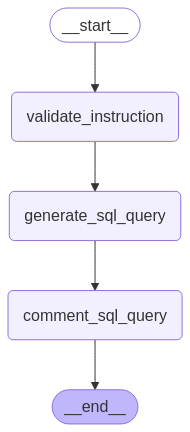

In [3]:
from langgraph.graph import StateGraph, START, END
from typing import List
from langgraph.checkpoint.memory import MemorySaver
import json
memory = MemorySaver()

from dataclasses import dataclass
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

# Ваша обёртка над моделью, pseudo:
# from my_llm_wrapper import llm

@dataclass
class MessagesState:
    messages: List[AIMessage]

def append_to_json_file(filename, record: dict):
    """
    Записывает строку JSON в указанный файл, добавляя (append) в конец.
    """
    with open(filename, 'a', encoding='utf-8') as f:
        json.dump(record, f, ensure_ascii=False)
        f.write('\n')  # перевод строки для хранения отдельных записей

def load_history_from_json(filename: str) -> list:
    """
    Считывает все строки из `filename`, парсит JSON 
    и формирует список сообщений HumanMessage/AIMessage 
    (в порядке, в котором они записаны в файле).
    """
    messages = []
    try:
        with open(filename, 'r', encoding='utf-8') as f:
            for line in f:
                line = line.strip()
                if not line:
                    continue
                record = json.loads(line)
                msg_type = record.get("type")
                content = record.get("content", "")
                
                if msg_type == "human_answer":
                    # Считаем это пользовательским сообщением
                    messages.append(HumanMessage(content=content))
                elif msg_type == "agent_answer":
                    # Считаем это ответом модели
                    messages.append(AIMessage(content=content))
                else:
                    # Если в файле есть другие типы — можно либо игнорировать,
                    # либо обрабатывать как SystemMessage, если нужно.
                    pass
    except FileNotFoundError:
        # Файл может не существовать при первом запуске
        pass
    
    return messages

#
# Узел 1: Проверка вопроса, при необходимости переспрашивает, 
# пока не получит "ok" – значит, всё скорректировано.
#
def validate_instruction(state: MessagesState) -> MessagesState:
    """
    На этом шаге:
    1) Модель проверяет, нет ли несостыковок между запросом пользователя и данными.
    2) Если всё ок, в ответе возвращает "ok".
    3) Когда ответ "ok", мы ещё раз просим кратко сформулировать "конкретную инструкцию"
    4) Этот результат используем как вход для следующей ноды, чтобы генератор SQL точно знал,
       какие поля выводить и как.
    """
    user_instruction = state.messages[0].content.strip()

    history_messages = load_history_from_json("gpt_db/data/dialogs_cash/history.json")

    sys_msg = SystemMessage(content=(
        f"Вот описание структуры:\n{otgruzki_structure}\n\n"
        f"Дивизионы:\n{divisions}\n"
        f"Сегодняшняя дата: {datetime.date.today().strftime('%Y%m%d')}\n\n"
        "Ты ассистент, проверяющий инструкцию пользователя. "
        "1) Нет ли несостыковок между запросом пользователя и доступными полями. "
        "2) Должно быть точно понятно какие поля выводить, если это не так то спрашивай какие есть варианты для вывода.\n"
        "3) Запрещено выводить все поля, спрашивай какие поля выводить если непонятно\n"
        "Если что-то не ясно, попроси уточнить (коротко)"
        "Если всё ок, ответь 'ok' и далее напиши скорректированную конкретную инструкцию. "
        "НЕ говори, что нет поля даты, оно точно есть."
        "Отвечай строго одним предложением для уточнений или 'ok' вместе с новой инструкцией. Без воды."
    ))

    # === КАСТОМНОЕ СОХРАНЕНИЕ В ФАЙЛ ===
    record = {
        "timestamp": str(datetime.datetime.now()),
        "type": "human_answer",
        "content": user_instruction
    }
    append_to_json_file("gpt_db/data/dialogs_cash/history.json", record)
    # ==================================

    user_instruction = f"Пользовательский запрос: {user_instruction}"

    human_msg = HumanMessage(content=user_instruction)
    conversation = [sys_msg] + history_messages + [human_msg]
    print(human_msg.content)
    while True:
        response = llm.invoke(conversation)
        conversation.append(response)
        result_text = response.content.strip()

        # Проверяем, ответил ли ассистент "ok"
        lower_text = result_text.lower()
        if lower_text.startswith("ok") or lower_text.startswith("ок"):
            # Модель сообщила, что всё в порядке.
            
            # === КАСТОМНОЕ СОХРАНЕНИЕ В ФАЙЛ ===
            record = {
                "timestamp": str(datetime.datetime.now()),
                "type": "agent_answer",
                "content": lower_text
            }
            append_to_json_file("gpt_db/data/dialogs_cash/history.json", record)
            # ==================================

            lower_text = lower_text[2:]
            print("✅ Инструкция принята:", lower_text)

            # Возвращаем это финальное сообщение в State
            return MessagesState(messages=[AIMessage(content=lower_text)])
        else:
            # Модель просит уточнений
            print("⚠️ Уточнение от модели:", result_text)
            clarification = input("🔄 Введите уточнённую инструкцию: "+result_text)
            if not clarification.strip():
                raise KeyError("Пользователь не дал уточнение, прерывание.")

            # Добавляем уточнение пользователя
            conversation.append(HumanMessage(content=clarification))
            print("USER INSTRUCTION", user_instruction)

            # === КАСТОМНОЕ СОХРАНЕНИЕ В ФАЙЛ ===
            record = {
                "timestamp": str(datetime.datetime.now()),
                "type": "agent_answer",
                "content": result_text
            }
            append_to_json_file("gpt_db/data/dialogs_cash/history.json", record)
            # ==================================

            # === КАСТОМНОЕ СОХРАНЕНИЕ В ФАЙЛ ===
            record = {
                "timestamp": str(datetime.datetime.now()),
                "type": "human_answer",
                "content": clarification
            }
            append_to_json_file("gpt_db/data/dialogs_cash/history.json", record)
            # ==================================

            user_instruction += f"\nВопрос от модели: {result_text}\nОтвет человека: {clarification}\n"


#
# Узел 2: Генерация SQL по строгому формату
#
def generate_sql_query(state: MessagesState) -> MessagesState:
    """
    Берём итоговую формулировку (после валидации) из state.messages[-1].content
    и просим модель сгенерировать SQL по жёстким правилам
    (GROUP BY для характеристик, SUM/COUNT для показателей, нет SELECT *, etc.).
    """
    user_query = state.messages[-1].content.strip()
    
    sys_msg = SystemMessage(content=(
        "Ты – эксперт по SQL (HANA) и анализу данных. Все запросы идут ТОЛЬКО к таблице:\n"
        "SAPABAP1.ZZSDM_117_CUS\n"
        "Схема таблицы"
        "[otgruzki_structure]\n"
        "Дополнительные данные:\n"
        "[divizions] (коды и названия дивизионов)\n"
        "Сегодняшняя дата - [date]"
        "Строгие правила:\n"
        " - Один показатель (если явно не прописано другого)\n"
        " - Только существующие поля (из otgruzki_structure)\n"
        " - Группировка (GROUP BY) по 'характеристикам'\n"
        " - Агрегация (SUM/COUNT) для 'показателей'\n"
        " - Явная дата в WHERE: формат 'YYYYMMDD'\n"
        " - Не показывать данные за все время\n"
        " - По умолчанию цены в рублях\n"
        " - Проверка деления на 0: CASE WHEN ...\n"
        " - LIMIT 1, если не указано иное\n"
        " - Отгрузки считаем по коду фактуры\n"
        " - Запрещено: WITH, NULLIF, SELECT *, ...\n"
        " - Наценка = (маржа / себестоимость) * 100\n\n"
        "Ответ дай ТОЛЬКО в виде SQL-запроса, без всяких пояснений и приписок."
    ).replace("[otgruzki_structure]", otgruzki_structure).replace("[divizions]", divisions).replace("[date]", str(datetime.datetime.now())[:10]))
    human_msg = HumanMessage(content=user_query)
    conversation = [sys_msg, human_msg]

    response = llm.invoke(conversation)
    sql_query = response.content.strip()

    return MessagesState(messages=state.messages[-1] + [AIMessage(content=sql_query)])


#
# Узел 3: Генерация комментария и сборка финального результата
#
def comment_sql_query(state: MessagesState) -> MessagesState:
    """
    Берём SQL из предыдущего шага, просим модель дать комментарий по формату:
       SELECT ...
       ===
       "Комментарий"
    (можно разбить, чтобы в одном сообщении был только SQL, а в другом комментарий,
    но ниже вариант, когда всё объединяется в один ответ).
    """
    question = state.messages[-2].content.strip()
    sql_query = state.messages[-1].content.strip()

    sys_msg = SystemMessage(content=(
        "Напиши ответ на запрос пользователя в настоящем времени, используя SQL запрос.\n"
        "Конечному пользователю SQL запрос виден не будет.\n"
        "Формат ответа:\n"
        " - Используй placeholders вида <поле1>, <поле2> и т.д. - из SQL запроса \n"
        " - Укажи, по какому дивизиону (если был фильтр) и какие точные даты (из WHERE)\n"
        " - Упомяни, какие формулы используются\n"
        "Никаких лишних слов."
    ))
    human_msg = HumanMessage(content=(f"Вот это запрос от пользователя: {question}\n"
                             f"\nВот SQL:\n{sql_query}\nСформируй итоговый ответ."))
    conversation = [sys_msg, human_msg]

    response = llm.invoke(conversation)
    final_answer = sql_query+"\n===\n"+response.content.strip()

    # # === КАСТОМНОЕ СОХРАНЕНИЕ В ФАЙЛ ===
    # record = {
    #     "timestamp": str(datetime.datetime.now()),
    #     "type": "agent_answer",
    #     "content": final_answer
    # }
    # append_to_json_file("gpt_db/data/dialogs_cash/history.json", record)
    # # ==================================

    return MessagesState(messages=[AIMessage(content=final_answer)])


# -----------------------
# Сборка графа
builder = StateGraph(MessagesState)

builder.add_node("validate_instruction", validate_instruction)
builder.add_node("generate_sql_query", generate_sql_query)
builder.add_node("comment_sql_query", comment_sql_query)

builder.add_edge(START, "validate_instruction")
builder.add_edge("validate_instruction", "generate_sql_query")
builder.add_edge("generate_sql_query", "comment_sql_query")
builder.add_edge("comment_sql_query", END)

# Компилируем агента
final_agent = builder.compile()

from IPython.display import Image, display

display(Image(final_agent.get_graph(xray=True).draw_mermaid_png()))


## Memory

In [5]:
user_querys = [
        
        "Покажи отгрузки за сегодня",
        "Сколько в прошлом месяце отгрузили на Урале",
        "Сколько клиентов отгрузилось на дальнем востоке в прошлом году",
            "Кто из них грузился чаще?",
        "Какой менеджер совершил больше всего продаж в прошлом месяце?",
            "посчитай по тоннажу",
        "В какой день было больше всего отгрузок?",
        "Скажи материал с самой большой наценкой",
        "Скажи АГ1 с самой большой наценкой",
        "Назови топ 10 клиентов за прошлый год",
        "У каких материалов самая большая себестоимость за прошлую неделю?",
        "Назови топ 3 дивизиона за прошлый месяц",
            "Назови выручку по этим дивизионам ",
        "Сколько вчера отгрузили в Японии?"
    ]

In [6]:
user_querys[2]

'Сколько клиентов отгрузилось на дальнем востоке в прошлом году'

In [ ]:
# messages = [HumanMessage(content="Придерживайся строгой формы ответы, это важно! один SQL запрос и один комментарий, если непонятно переспроси")]
messages = [HumanMessage(content=user_querys[1])]

messages = final_agent.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

Пользовательский запрос: Покажи отгрузки за сегодня
✅ Инструкция принята:   
вывести поля: код фактуры (vbrk_vbeln), дата оформления фактуры (vbrk_fkdat), клиент (zcustomer), выручка в рублях (zarevenf_rub); фильтровать по дате: vbrk_fkdat равна сегодняшней дате (20250402).
================================== Ai Message ==================================

```sql
SELECT 
    VBRK_VBELN,
    VBRK_FKDAT,
    ZCUSTOMER,
    ZAREVENF_RUB
FROM 
    SAPABAP1.ZZSDM_117_CUS
WHERE 
    VBRK_FKDAT = '20250402';
```
===
Выводятся следующие данные за 2 апреля 2025 года без учета дивизиона:
- Код фактуры (<VBRK_VBELN>)
- Дата оформления фактуры (<VBRK_FKDAT>)
- Клиент (<ZCUSTOMER>)
- Выручка в рублях (<ZAREVENF_RUB>)


In [98]:
# messages = [HumanMessage(content="Придерживайся строгой формы ответы, это важно! один SQL запрос и один комментарий, если непонятно переспроси")]
messages = [HumanMessage(content="3")]

messages = final_agent.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

Пользовательский запрос: Сегодня апрель, пропиши точно прошлый месяц.
✅ Инструкция принята:   
вывести поле "количество в килограммах" (fkimg_kg); фильтровать по дивизиону (zdiv): урал (значение 02); период: март 2025 года.
================================== Ai Message ==================================

```sql
SELECT SUM(FKIMG_KG) AS total_fkimg_kg
FROM SAPABAP1.ZZSDM_117_CUS
WHERE ZDIV = '02' AND FKDAT BETWEEN '20250301' AND '20250331';
```
===
В дивизионе Урал за март 2025 года общее количество в килограммах составляет **<total_fkimg_kg>** кг.
